In [ ]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax , AdamW, SGD, Adadelta, Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import random
import tifffile as tiff

BASE_DIR = r'C:\py_works\wildfire_v3'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 200

def custom_augment(image, rotation_range=20, width_shift_range=0.2, 
                  height_shift_range=0.2, zoom_range=0.2, 
                  horizontal_flip=True, fill_mode='nearest'):
    h, w = image.shape[:2]
    output = image.copy()
    

    tx = np.random.uniform(-width_shift_range, width_shift_range) * w if width_shift_range > 0 else 0
    
    ty = np.random.uniform(-height_shift_range, height_shift_range) * h if height_shift_range > 0 else 0
    
    angle = np.random.uniform(-rotation_range, rotation_range)
    
    zoom = np.random.uniform(1 - zoom_range, 1 + zoom_range)
    

    M = cv2.getRotationMatrix2D((w/2, h/2), angle, zoom)
    M[0,2] += tx
    M[1,2] += ty
    

    border_mode = cv2.BORDER_REPLICATE if fill_mode == 'nearest' else cv2.BORDER_CONSTANT
    output = cv2.warpAffine(output, M, (w,h), flags=cv2.INTER_LINEAR, borderMode=border_mode)

    if horizontal_flip and random.random() < 0.5:
        output = cv2.flip(output, 1)
        
    return output


def tf_custom_augment(image, label):
    augmented_image = tf.numpy_function(
        func=lambda x: custom_augment(x),
        inp=[image],
        Tout=tf.float32
    )
    augmented_image.set_shape([224, 224, 3])  
    return augmented_image, label



def alexnet_preprocess_input(x):
    return (tf.cast(x, tf.float32) / 32767.5) - 1.0


def load_and_preprocess(path, label):
    
    img = tf.numpy_function(
        lambda p: tiff.imread(p.decode('utf-8')).astype(np.float32), 
        [path], 
        tf.float32
    )
    
    
    img = tf.ensure_shape(img, (None, None, 3))  
    img = tf.image.resize(img, [224, 224])       
    
    
    img = (img / 32767.5) - 1.0
    return img, label



def create_dataset(files, labels, augment=False, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((files, labels))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(files))
    
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        dataset = dataset.map(tf_custom_augment, num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



def get_file_paths_and_labels():
    fire_dir = os.path.join(BASE_DIR, 'fire')
    nofire_dir = os.path.join(BASE_DIR, 'nofire')
    
    fire_files = [os.path.join(fire_dir, f) for f in os.listdir(fire_dir) if f.endswith('.tiff')]
    nofire_files = [os.path.join(nofire_dir, f) for f in os.listdir(nofire_dir) if f.endswith('.tiff')]
    
    random.shuffle(fire_files)
    random.shuffle(nofire_files)
    
    return (fire_files, [1]*len(fire_files)), (nofire_files, [0]*len(nofire_files))

def split_dataset(files, labels):
    total = len(files)
    train_end = int(0.8 * total)
    val_end = train_end + int(0.1 * total)
    return ((files[:train_end], labels[:train_end]),
            (files[train_end:val_end], labels[train_end:val_end]),
            (files[val_end:], labels[val_end:]))

(fire_files, fire_labels), (nofire_files, nofire_labels) = get_file_paths_and_labels()
(fire_train, fire_val, fire_test) = split_dataset(fire_files, fire_labels)
(nofire_train, nofire_val, nofire_test) = split_dataset(nofire_files, nofire_labels)

def combine_splits(*class_splits):
    return (sum((s[0] for s in class_splits), []),
            sum((s[1] for s in class_splits), []))

train_files, train_labels = combine_splits(fire_train, nofire_train)
val_files, val_labels = combine_splits(fire_val, nofire_val)
test_files, test_labels = combine_splits(fire_test, nofire_test)

train_dataset = create_dataset(train_files, train_labels, augment=True, shuffle=True)
val_dataset = create_dataset(val_files, val_labels, augment=False, shuffle=False)
test_dataset = create_dataset(test_files, test_labels, augment=False, shuffle=False)

In [3]:
for image_batch, label_batch in train_dataset.take(1):
    print("Image dtype:", image_batch.dtype)
    print("Label dtype:", label_batch.dtype)

Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


In [4]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for image_batch, label_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [ ]:
import numpy as np

min_val = float('inf')
max_val = -float('inf')

for batch_images, _ in train_dataset:

    batch_min = np.min(batch_images)
    batch_max = np.max(batch_images)
    

    min_val = min(min_val, batch_min)
    max_val = max(max_val, batch_max)


print(f"Minimum value in training data: {min_val}")
print(f"Maximum value in training data: {max_val}")


Minimum value in training data: -1.0
Maximum value in training data: 1.0


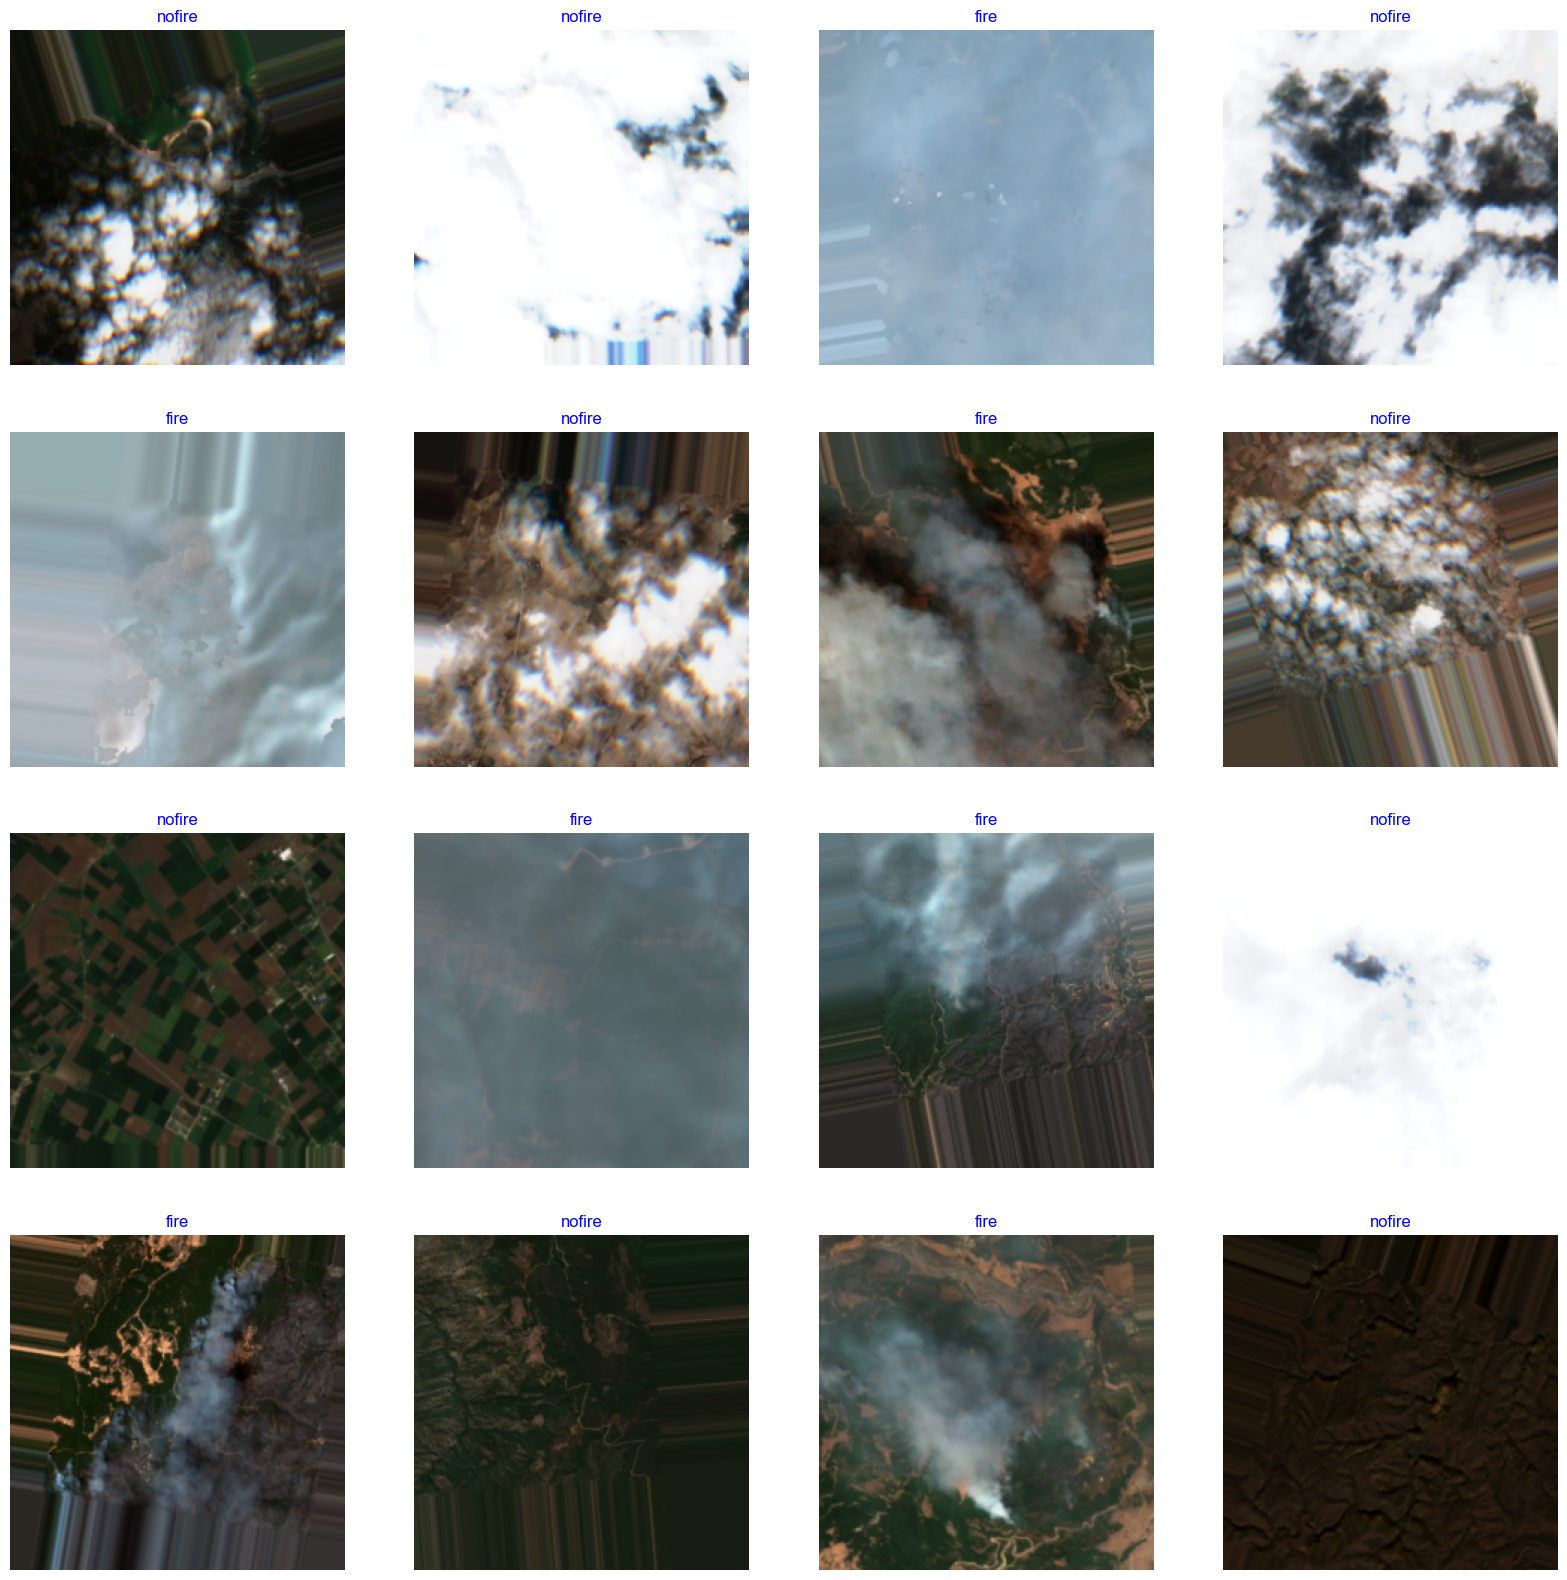

In [ ]:
classes = ["nofire", "fire"]

images, labels = next(iter(train_dataset))
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = (((images[i].numpy() + 1.0) * 127.5)).astype("uint8") 
    plt.imshow(image)
    class_index = int(labels[i].numpy())
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()


In [ ]:
img_shape = (224, 224, 3)  
num_classes = 1  


inputs = keras.Input(shape=(img_shape))
x = layers.Conv2D(filters=16,kernel_size=11,padding="same",use_bias=False)(inputs)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling2D(pool_size=3)(x)

x = layers.Conv2D(filters=32,kernel_size=5,padding="same",use_bias=False)(x)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64,kernel_size=3,padding="same",use_bias=False)(x)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128,kernel_size=3,padding="same",use_bias=False)(x)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256,kernel_size=3,padding="same",use_bias=False)(x)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)


x = layers.Flatten()(x)

x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="sigmoid")(x)

model = keras.Model(inputs=inputs,outputs=outputs)

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │         5,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 32)     │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 256)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,487,537 (5.67 MB)

 Trainable params: 1,487,537 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

print("\nDataset shapes:")
print(f"Train: {len(train_files)} samples")
print(f"Val: {len(val_files)} samples")
print(f"Test: {len(test_files)} samples")


for x, y in train_dataset.take(1):
    print(f"\nInput batch shape: {x.shape}, Output batch shape: {y.shape}")
    assert x.shape == (BATCH_SIZE, 224, 224, 3), "Input shape mismatch!"
    assert y.shape == (BATCH_SIZE,), "Output shape mismatch!"


Dataset shapes:
Train: 488 samples
Val: 60 samples
Test: 63 samples

Input batch shape: (32, 224, 224, 3), Output batch shape: (32,)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0,
    mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)

model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",  
    monitor="val_accuracy",       
    mode="max",                   
    save_best_only=True,          
    verbose=0
)

plateau = ReduceLROnPlateau(
    patience=4,
    mode=min,
    monitor='val_loss',
    factor=.2,
    verbose=0
)

In [12]:
model.compile(
    optimizer=Adam(learning_rate=1e-4, weight_decay=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, plateau, model_checkpoint]
)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 774ms/step - accuracy: 0.4979 - loss: 0.6668 - val_accuracy: 0.6167 - val_loss: 0.6236 - learning_rate: 1.0000e-04
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - accuracy: 0.6314 - loss: 0.6443 - val_accuracy: 0.7167 - val_loss: 0.5735 - learning_rate: 1.0000e-04
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 793ms/step - accuracy: 0.6875 - loss: 0.5883 - val_accuracy: 0.8333 - val_loss: 0.3946 - learning_rate: 1.0000e-04
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 822ms/step - accuracy: 0.7577 - loss: 0.4929 - val_accuracy: 0.8667 - val_loss: 0.2647 - learning_rate: 1.0000e-04
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 953ms/step - accuracy: 0.8196 - loss: 0.3978 - val_accuracy: 0.8167 - val_loss: 0.3842 - learning_rate: 1.0000e-04
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 959ms/step - accuracy: 0.7917 - loss: 0.4420 - val_accuracy: 0.8667 - val_loss: 0.2543 - learning_rate: 1.0000e-04
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 863ms/ste

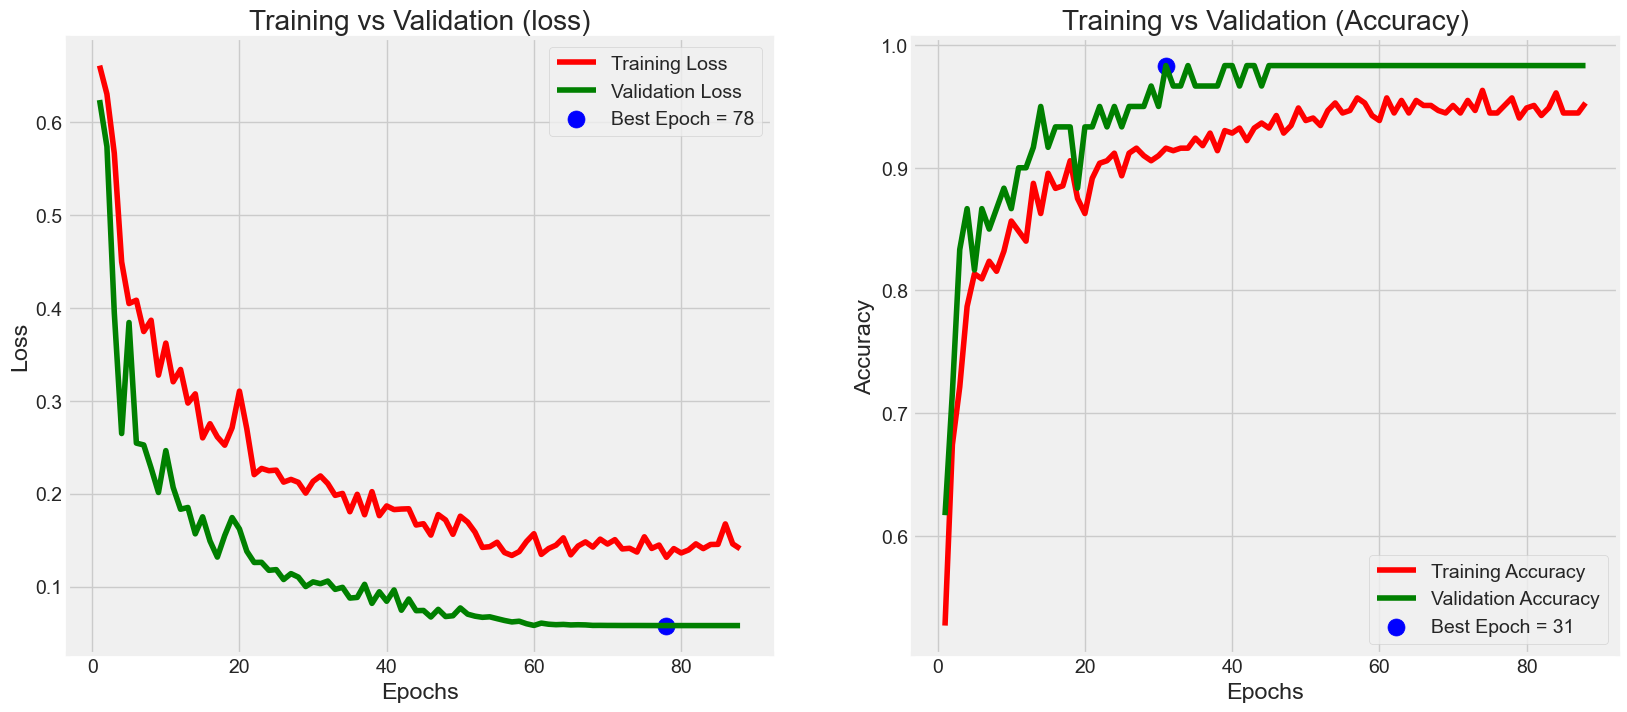

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();

In [15]:
train_score = model.evaluate(train_dataset , steps= 32 , verbose = 1)
val_score = model.evaluate(val_dataset , steps = 32 , verbose = 1)
test_score = model.evaluate(test_dataset , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - accuracy: 0.9652 - loss: 0.1247
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9829 - loss: 0.0587  
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9673 - loss: 0.1159  
Train loss = 0.12502482533454895
Train Accuracy = 0.9610655903816223
Validation loss = 0.05793898552656174
Validation Accuracy = 0.9833333492279053
Test loss = 0.11388380080461502
Test Accuracy = 0.9682539701461792


In [20]:
model = tf.keras.models.load_model("best_model.keras")

In [4]:
train_score = model.evaluate(train_dataset , steps= 32 , verbose = 1)
val_score = model.evaluate(val_dataset , steps = 32 , verbose = 1)
test_score = model.evaluate(test_dataset , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.9596 - loss: 0.1057
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9677 - loss: 0.1728 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9673 - loss: 0.1068  
Train loss = 0.1162530705332756
Train Accuracy = 0.9528688788414001
Validation loss = 0.17549480497837067
Validation Accuracy = 0.9666666388511658
Test loss = 0.10539529472589493
Test Accuracy = 0.9682539701461792


In [ ]:

preds = model.predict(test_dataset)

predicted_classes = (preds > 0.5).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step


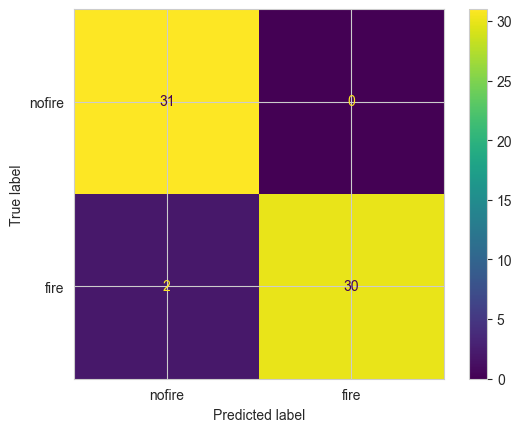

In [6]:
true_classes = []
for _, labels in test_dataset:
    true_classes.extend(labels.numpy())

true_classes = np.array(true_classes)

confusion = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["nofire", "fire"])
disp.plot(cmap='viridis', values_format='d')

In [7]:
from sklearn.metrics import classification_report

target_names = ['nofire', 'fire']
classification_rep = classification_report(true_classes, predicted_classes, target_names=target_names)
print("\nClassification Report:")
print(classification_rep)



Classification Report:
              precision    recall  f1-score   support

      nofire       0.94      1.00      0.97        31
        fire       1.00      0.94      0.97        32

    accuracy                           0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63



In [19]:
model.save("np_adam.keras")

In [3]:
model = tf.keras.models.load_model("np_adam.keras")

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "C:\py_works\content/img.tiff"
img = tiff.imread(img_path)
img = tf.image.resize(img, (224,224))
img = alexnet_preprocess_input(img)

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)



In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
✅ No Wildfire.


In [10]:
prediction

array([[0.21697974]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image


img_path = "C:\py_works\content/img1.tiff"
img = tiff.imread(img_path)
img = tf.image.resize(img, (224,224))
img = alexnet_preprocess_input(img)


img_array = image.img_to_array(img)


img_array = np.expand_dims(img_array, axis=0)



In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
✅ No Wildfire.


In [13]:
prediction

array([[0.00021906]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image


img_path = "C:\py_works\content/img2.tiff"
img = image.load_img(img_path, target_size=(224, 224))
img = alexnet_preprocess_input(img)


img_array = image.img_to_array(img)


img_array = np.expand_dims(img_array, axis=0)


In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
✅ No Wildfire.


In [16]:
prediction

array([[0.01835496]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image


img_path = "C:\py_works\content/img5.tiff"
img = tiff.imread(img_path)
img = tf.image.resize(img, (224,224))
img = alexnet_preprocess_input(img)


img_array = image.img_to_array(img)


img_array = np.expand_dims(img_array, axis=0)



In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
✅ No Wildfire.


In [17]:
prediction

array([[0.25846925]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image

def default_preprocess(x):
    normalized_image = (tf.cast(x,tf.float32) / 127.5) - 1.0
    return normalized_image


img_path = "C:\py_works\content/img7.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img = default_preprocess(img)
img_array = image.img_to_array(img)


img_array = np.expand_dims(img_array, axis=0)



In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
🔥 Wildfire Detected!


In [20]:
prediction

array([[0.9992411]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image

def default_preprocess(x):
    normalized_image = (tf.cast(x,tf.float32) / 127.5) - 1.0
    return normalized_image


img_path = "C:\py_works\content/img8.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img = default_preprocess(img)
img_array = image.img_to_array(img)


img_array = np.expand_dims(img_array, axis=0)



In [ ]:

prediction = model.predict(img_array)


if prediction[0][0] < 0.5:
    print("✅ No Wildfire.")

else:
  print("🔥 Wildfire Detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
🔥 Wildfire Detected!


In [23]:
prediction

array([[0.9182685]], dtype=float32)